 ## Aim of the algorithm

This algorithm aims for the computation of the evolution/emergence of altruism in a population composed of breeders, offspring and waiters. To do so, we set some parameters and compute the evolution of the eigenvalues in function of the altruism parameter, h_x/eta_x and on the value of some parameters depending on the experiments.

## Libraries

In [1]:
using LinearAlgebra
using Plots
using LaTeXStrings

## Parameters

In [25]:
#survivals:
s_u = 0.5
s_w = 0.5
s_x = 0.5
s_y = 0.5
s_ox = 0.8
s_oy = 0.6

#fecundity
b_x = 3
b_y = 5
phi = 0.01
M = 3
theta_x(x,y) = (1-phi)*x/(x+y)
theta_y(x,y) = (1-phi)*y/(x+y) 
psi_x(x,y) = theta_x(x,y)+1+phi
psi_y(x,y) = theta_y(x,y)+1+phi


#altruism
h_x = 0
h_y = 0
alpha = 1
beta = 1
T_x(h_x) = 1-alpha*exp(-h_x*b_x)
T_y(h_y) = beta*exp(-h_y*b_y)

#competition
a = 1
p_u = 0.5
p_u_tilde(x,y) = p_u/(1+a*(x+y))
p_w = 0.5
p_w_tilde(x,y) = p_w/(1+a*(x+y))

parameters = [b_x,b_y,s_u,s_w,s_ox,s_oy,s_x,s_y,phi,M,a,p_u,p_w]

#Eigenvector
nu_u = 1
nu_w(x,y) = ((1-T_x(h_x))*s_ox+T_x(h_x)*s_y)*s_w*p_w*(1-s_u*(1-p_u_tilde(x,y)))/(s_u*p_u*(1-s_w*(1-p_w_tilde(x,y))))*nu_u
nu_y = 1/(1-T_x(h_x)*s_y*T_y(h_y)*s_x/(1-s_x*(1-T_x(h_x))))*((1-T_y(h_y))*s_y*b_y/(1-s_y*(1-T_y(h_y)))+T_y(h_y)*s_x*b_x/(1-s_y*(1-T_y(h_y)))+T_y(h_y)*s_x*((1-T_x(h_x))*s_x*b_x+T_x(h_x)*s_y*b_y)/(1-s_y*(1-T_y(h_y)))/(1-s_x*(1-T_x(h_x))))
nu_x = 1/(1-s_x*(1-T_x(h_x)))*((1-T_x(h_x))*s_x*b_x+T_x(h_x)*s_y*b_y+T_x(h_x)*nu_y)
nu_ox(x,y)= (1-h_x)+h_x*((1-T_x(h_x))*s_x+T_x(h_x)*s_y)*nu_w(x,y)
nu_oy(x,y) = (1-h_x)+h_x*((1-T_x(h_x))*s_x+T_x(h_x)*s_y)*nu_w(x,y)

mu_u(x,y) = s_u*(1-p_u_tilde(x,y))/(1-s_u*(1-p_u_tilde(x,y)))*((1-h_x)*b_x+(1-h_y)*b_y*T_x(h_x)*s_y/(1-s_y*(1-T_y(h_y))))
mu_w(x,y) = (h_x*(1-T_x(h_x))*s_ox+h_x*T_x(h_x)*s_y+h_y*(1-T_y(h_y))*s_y+h_y*T_y(h_y)*s_x)/(1-s_w*(1-p_w_tilde(x,y)))
mu_x = 1
mu_y(x,y) = T_x(h_x)*s_y/(1-s_w*(1-p_w_tilde(x,y)))
mu_ox = b_x
mu_oy(x,y) = b_y*mu_y(x,y)

#time
t_0 = 0
t_max = 1000

#Relatedness
R_op = 1/2*(1+phi)
R_om = phi^2+(1-phi)^2*(1/4+1/(4*M));


## Simulation

Matrix A(x,y):

In [26]:
A(x,y) = [s_u*(1-p_u_tilde(x,y)) 0 0 0 (1-h_x)*s_u*(1-p_u_tilde(x,y)) (1-h_y)*s_u*(1-p_u_tilde(x,y))
;0 s_w*(1-p_w_tilde(x,y)) 0 0 h_x*((1-T_x(h_x))*s_ox+T_x(h_x)*s_oy) h_y*((1-T_y(h_y))*s_oy+T_y(h_y)*s_ox)
; s_u*p_u_tilde(x,y) s_w*p_w_tilde(x,y) (1-T_x(h_x))*s_x T_y(h_y)*s_x (1-h_x)*s_u*p_u_tilde(x,y) (1-h_y)*s_u*p_u_tilde(x,y)
; 0 0 T_x(h_x)*s_y (1-T_y(h_y))*s_y 0 0
; s_u*p_u_tilde(x,y)*b_x/2*psi_x(x,y) s_w*p_w_tilde(x,y)*b_x/2*psi_x(x,y) (1-T_x(h_x))*s_x*b_x/2*psi_x(x,y)+T_x(h_x)*s_y*b_x/2*theta_x(x,y) T_y(h_y)*s_x*b_x/2*psi_x(x,y)+(1-T_y(h_y))*s_y*b_x/2*theta_x(x,y) (1-h_x)*s_u*p_u_tilde(x,y)*b_x/2*psi_x(x,y) (1-h_y)*s_u*p_u_tilde(x,y)*b_x/2*psi_x(x,y)
; s_u*p_u_tilde(x,y)*b_y/2*theta_y(x,y) s_w*p_w_tilde(x,y)*b_y/2*theta_y(x,y) (1-T_x(h_x))*s_x*b_y/2*theta_y(x,y)+T_x(h_x)*s_y*b_y/2*psi_y(x,y) T_y(h_y)*s_x*b_y/2*theta_y(x,y)+(1-T_y(h_y))*s_y*b_y/2*psi_y(x,y) (1-h_x)*s_u*p_u_tilde(x,y)*b_y/2*theta_y(x,y) (1-h_y)*s_u*p_u_tilde(x,y)*b_y/2*theta_y(x,y)
];
A(1,1)

6×6 Matrix{Float64}:
 0.416667   0.0        0.0      0.0      0.416667   0.416667
 0.0        0.416667   0.0      0.0      0.0        0.0
 0.0833333  0.0833333  0.5      0.5      0.0833333  0.0833333
 0.0        0.0        0.0      0.0      0.0        0.0
 0.188125   0.188125   1.12875  1.12875  0.188125   0.188125
 0.103125   0.103125   0.61875  0.61875  0.103125   0.103125

Equilibrium:

In [27]:
function equilibrium()
    pop = transpose([1 1 1 1 1 1])
    for t in t_0:t_max
        pop = A(pop[3], pop[4])*pop
    end
    return pop
end;
println(equilibrium())

[2.9999999999999996; 0.0; 1.4999999999999998; 0.0; 4.499999999999999; 0.0;;]


# ESS

In [41]:
function ESS(parameters)
    b_x = parameters["b_x"]
    b_y = parameters["b_y"]
    s_u = parameters["s_u"]
    s_w = parameters["s_w"]
    s_ox = parameters["s_ox"]
    s_oy = parameters["s_oy"]
    s_x = parameters["s_x"]
    s_y = parameters["s_y"]
    p_u = parameters["p_u"]
    p_w = parameters["p_w"]
    a = parameters["a"]
    M = parameters["M"]
    phi = parameters["phi"]
    pop = equilibrium()
    x_bar = pop[3]
    y_bar = pop[4]
    
    eps = 0.01
    h_x = 0
    h_y = 0
    DW_x(h_x) = mu_x*b_x*(1-T_x(h_x))*R_op*(s_y*nu_y-s_x*nu_x+s_y*((1+phi)*b_y/2*nu_oy(x_bar,y_bar)+(1-phi)*b_x/2*x_bar/(x_bar+y_bar)*nu_ox(x_bar,y_bar)+(1-phi)*b_y/2*y_bar/(x_bar+y_bar)*nu_oy(x_bar,y_bar))-s_x*((1+phi)*b_x/2*nu_ox(x_bar,y_bar)+(1-phi)*b_x/2*x_bar/(x_bar+y_bar)*nu_ox(x_bar,y_bar)+(1-phi)*b_y/2*y_bar/(x_bar+y_bar)*nu_oy(x_bar,y_bar)))-mu_ox*(1-((1-T_x(h_x))*s_ox+T_x(h_x)*s_oy)*s_w*p_w*(1-s_u*(1-p_u_tilde(x_bar,y_bar)))/(s_u*p_u*(1-s_w*(1-p_w_tilde(x_bar,y_bar)))))*nu_u+mu_ox*h_x*b_x*(1-T_x(h_x))*R_om*(s_oy-s_ox)*nu_w(x_bar,y_bar)
    DW_y(h_y) = mu_y(x_bar,y_bar)*b_y*(T_y(h_y))*R_op*(s_y*nu_y-s_x*nu_x+s_y*((1+phi)*b_y/2*nu_oy(x_bar,y_bar)+(1-phi)*b_x/2*x_bar/(x_bar+y_bar)*nu_ox(x_bar,y_bar)+(1-phi)*b_y/2*y_bar/(x_bar+y_bar)*nu_oy(x_bar,y_bar))-s_x*((1+phi)*b_x/2*nu_ox(x_bar,y_bar)+(1-phi)*b_x/2*x_bar/(x_bar+y_bar)*nu_ox(x_bar,y_bar)+(1-phi)*b_y/2*y_bar/(x_bar+y_bar)*nu_oy(x_bar,y_bar)))-mu_oy(x_bar,y_bar)*(1-((1-T_y(h_y))*s_ox+T_y(h_y)*s_oy)*s_w*p_w*(1-s_u*(1-p_u_tilde(x_bar,y_bar)))/(s_u*p_u*(1-s_w*(1-p_w_tilde(x_bar,y_bar)))))*nu_u+mu_oy(x_bar,y_bar)*h_y*b_y*(T_y(h_y))*R_om*(s_oy-s_ox)*nu_w(x_bar,y_bar)
    
    for i in range(1,1000)
        h_x = h_x+eps*DW_x(h_x)
        h_y = h_y+DW_y(h_y)
        pop = equilibrium()
        x_bar = pop[3]
        y_bar = pop[4]
    end
    return h_x, h_y
end;

In [ ]:
b_x = 3
b_y = 10
s_u = 0.5
s_w = 0.5
s_x = 0.5
s_y = 0.5
s_ox = 0.6
s_oy = 0.6
phi = 0.01
M = 3
a = 1
p_u = 0.5
p_w = 0.5
phi = 0
parameters = Dict("b_x"=>b_x,"b_y"=>b_y,"s_u"=>s_u,"s_w"=>s_w,"s_ox"=>s_ox,"s_oy"=>s_oy,"s_x"=>s_x,"s_y"=>s_y,"phi"=>phi,"M"=>M,"a"=>a,"p_u"=>p_u,"p_w"=>p_w)

j = 1
N = 200
DWx_v = zeros(N+1)
DWy_v = zeros(N+1)

f_value = 1
x_space = 0:f_value/N:f_value
for s_ox in x_space
    parameters["s_ox"] = s_ox
    DWx_v[j] = ESS(parameters)[1]
    DWy_v[j] = ESS(parameters)[2]
    j+=1
end

plot(x_space,DWx_v,ylims=[0,1],label = "\$h_x\$")
plot!(x_space,DWy_v,ylims=[0,1],label = "\$h_x\$")
xlabel!("\$s_{o_x}\$")
ylabel!("\$h_x\$")

# Isoclines for emergence of cooperation

Change of survival for offspring

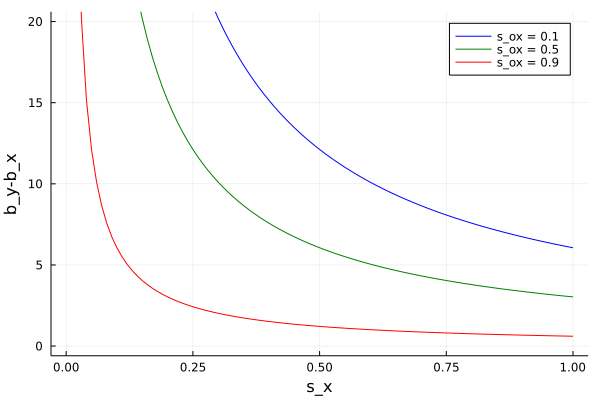

In [60]:
s_x =  0:0.01:1
h_x = 0
s_ox = 0.0001
delta = 2 .*(1 .-s_ox)./((1+phi).*(1-T_x(h_x))*R_op.*s_x)
plot(s_x,delta, color = "blue",label = "s_ox = 0.1",ylims = [0,20])

s_ox = 0.5
delta = 2*(1 .-s_ox)./((1+phi)*(1-T_x(h_x))*R_op.*s_x)
plot!(s_x,delta, color = "green",label = "s_ox = 0.5",ylims = [0,20])

s_ox = 0.9
delta = 2*(1 .-s_ox)./((1+phi)*(1-T_x(h_x))*R_op.*s_x)
plot!(s_x,delta, color = "red",label = "s_ox = 0.9",ylims = [0,20])

xlabel!("s_x")
ylabel!("b_y-b_x")

Change of M

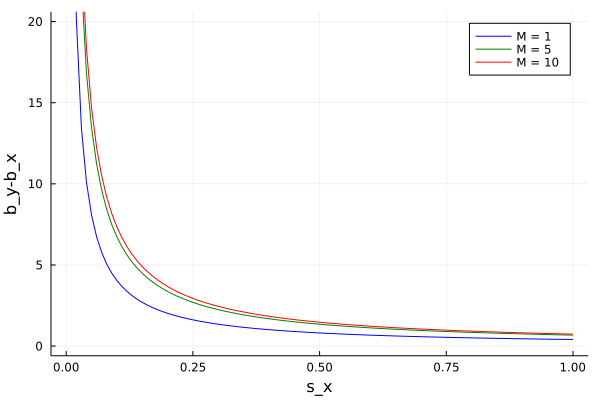

In [61]:
s_x =  0:0.01:1

M = 1
R_op = phi^2+(1-phi)^2*(1/4+1/(4*M));
delta = 2*(1 .-s_ox)./((1+phi)*(1-T_x(h_x))*R_op.*s_x)
plot(s_x,delta, color = "blue",label = "M = 1",ylims = [0,20])

M = 5
R_op = phi^2+(1-phi)^2*(1/4+1/(4*M));
delta = 2*(1 .-s_ox)./((1+phi)*(1-T_x(h_x))*R_op.*s_x)
plot!(s_x,delta, color = "green",label = "M = 5",ylims = [0,20])

M = 10
R_op = phi^2+(1-phi)^2*(1/4+1/(4*M));
delta = 2*(1 .-s_ox)./((1+phi)*(1-T_x(h_x))*R_op.*s_x)
plot!(s_x,delta, color = "red",label = "M = 10",ylims = [0,20])

xlabel!("s_x")
ylabel!("b_y-b_x")

Influence of phi

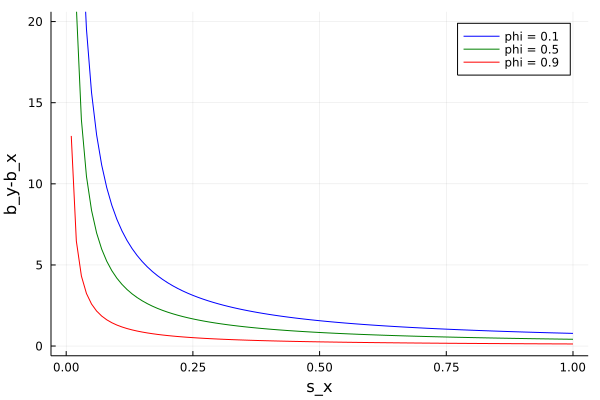

In [63]:
s_x =  0:0.01:1

phi = 0.1
R_op = phi^2+(1-phi)^2*(1/4+1/(4*M));
delta = 2*(1 .-s_ox)./((1+phi)*(1-T_x(h_x))*R_op.*s_x)
plot(s_x,delta, color = "blue",label = "phi = 0.1",ylims = [0,20])

phi = 0.5
R_op = phi^2+(1-phi)^2*(1/4+1/(4*M));
delta = 2*(1 .-s_ox)./((1+phi)*(1-T_x(h_x))*R_op.*s_x)
plot!(s_x,delta, color = "green",label = "phi = 0.5",ylims = [0,20])

phi = 0.9
R_op = phi^2+(1-phi)^2*(1/4+1/(4*M));
delta = 2*(1 .-s_ox)./((1+phi)*(1-T_x(h_x))*R_op.*s_x)
plot!(s_x,delta, color = "red",label = "phi = 0.9",ylims = [0,20])

xlabel!("s_x")
ylabel!("b_y-b_x")

In [ ]:
s_x

Influence of s_w/s_u ratio

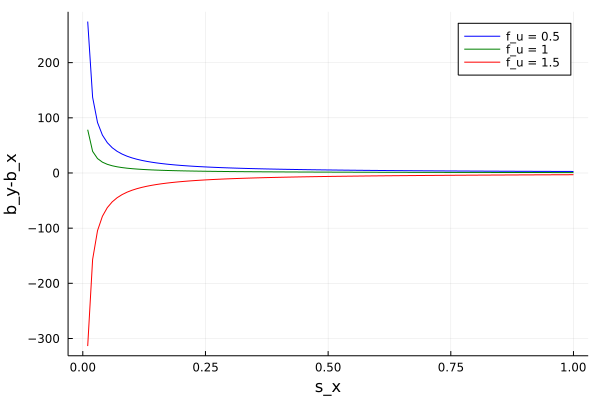

In [79]:
f_u = 0.5 #sw/su
i = 1
delta = zeros(101)
for s_x in 0:0.01:1
    pop = equilibrium()
    x_bar = pop[3]
    y_bar = pop[4]
    delta[i] = 2*(1 .-f_u.*(1-s_u*(1-p_u_tilde(x_bar,y_bar)))/((1-s_u*f_u*(1-p_u_tilde(x_bar,y_bar)))).*s_ox)./((1+phi)*(1-T_x(h_x))*R_op.*s_x)
    i+=1
end
plot(0:0.01:1,delta, color = "blue",label = "f_u = 0.5")

f_u = 1 #sw/su
i = 1

for s_x in 0:0.01:1
    pop = equilibrium()
    x_bar = pop[3]
    y_bar = pop[4]
    delta[i] = 2*(1 .-f_u.*(1-s_u*(1-p_u_tilde(x_bar,y_bar)))/((1-s_u*f_u*(1-p_u_tilde(x_bar,y_bar)))).*s_ox)./((1+phi)*(1-T_x(h_x))*R_op.*s_x)
    i+=1
end
plot!(0:0.01:1,delta, color = "green",label = "f_u = 1")

f_u = 1.5 #sw/su
i = 1

for s_x in 0:0.01:1
    pop = equilibrium()
    x_bar = pop[3]
    y_bar = pop[4]
    delta[i] = 2*(1 .-f_u.*(1-s_u*(1-p_u_tilde(x_bar,y_bar)))/((1-s_u*f_u*(1-p_u_tilde(x_bar,y_bar)))).*s_ox)./((1+phi)*(1-T_x(h_x))*R_op.*s_x)
    i+=1
end
plot!(0:0.01:1,delta, color = "red",label = "f_u = 1.5")

xlabel!("s_x")
ylabel!("b_y-b_x")

## T_x >0, s_y!=s_x

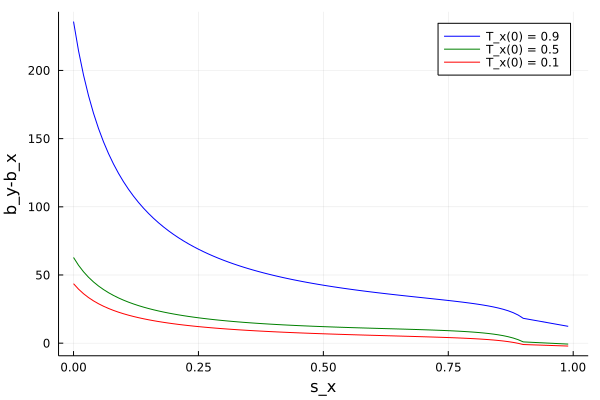

In [97]:
alpha = 0.1

delta = zeros(101)
i=1
S_X = 0:0.01:1
for s_x in 0:0.01:1
    
    #s_y = (1+s_x)/2
    s_y = min(s_x+0.1,1)
    nu_y = 1/(1-T_x(h_x)*s_y*T_y(h_y)*s_x/(1-s_x*(1-T_x(h_x))))*((1-T_y(h_y))*s_y*b_y/(1-s_y*(1-T_y(h_y)))+T_y(h_y)*s_x*b_x/(1-s_y*(1-T_y(h_y)))+T_y(h_y)*s_x*((1-T_x(h_x))*s_x*b_x+T_x(h_x)*s_y*b_y)/(1-s_y*(1-T_y(h_y)))/(1-s_x*(1-T_x(h_x))))
    nu_x = 1/(1-s_x*(1-T_x(h_x)))*((1-T_x(h_x))*s_x*b_x+T_x(h_x)*s_y*b_y+T_x(h_x)*nu_y)

    X,Y = equilibrium()
    s_ox = 0.1
    delta[i] = 2 .*(1 .-(1 .-T_x(h_x)).*s_ox.-T_x(h_x).*s_oy.-(s_y.*nu_y.-s_x.*nu_x).*(1 .-T_x(h_x)).*R_op.+b_x.*(s_y.-s_x).*R_op)./(((1 .-phi).*(s_y.-s_x).*Y./(X.+Y).+s_y.*(1 .+phi)).*(1 .-T_x(h_x)).*R_op)
    i+=1
end
plot(S_X,delta, color = "blue",label = "T_x(0) = 0.9")


i=1
alpha = 0.5

for s_x in 0:0.01:1
    
    #s_y = (1+s_x)/2
    s_y = min(s_x+0.1,1)
    nu_y = 1/(1-T_x(h_x)*s_y*T_y(h_y)*s_x/(1-s_x*(1-T_x(h_x))))*((1-T_y(h_y))*s_y*b_y/(1-s_y*(1-T_y(h_y)))+T_y(h_y)*s_x*b_x/(1-s_y*(1-T_y(h_y)))+T_y(h_y)*s_x*((1-T_x(h_x))*s_x*b_x+T_x(h_x)*s_y*b_y)/(1-s_y*(1-T_y(h_y)))/(1-s_x*(1-T_x(h_x))))
    nu_x = 1/(1-s_x*(1-T_x(h_x)))*((1-T_x(h_x))*s_x*b_x+T_x(h_x)*s_y*b_y+T_x(h_x)*nu_y)

    X,Y = equilibrium()
    s_ox = 0.1
    delta[i] = 2 .*(1 .-(1 .-T_x(h_x)).*s_ox.-T_x(h_x).*s_oy.-(s_y.*nu_y.-s_x.*nu_x).*(1 .-T_x(h_x)).*R_op.+b_x.*(s_y.-s_x).*R_op)./(((1 .-phi).*(s_y.-s_x).*Y./(X.+Y).+s_y.*(1 .+phi)).*(1 .-T_x(h_x)).*R_op)
    i+=1
end 
plot!(S_X,delta, color = "green",label = "T_x(0) = 0.5")

i=1
alpha = 0.9
for s_x in 0:0.01:1
    
    #s_y = (1+s_x)/2
    s_y = min(s_x+0.1,1)
    nu_y = 1/(1-T_x(h_x)*s_y*T_y(h_y)*s_x/(1-s_x*(1-T_x(h_x))))*((1-T_y(h_y))*s_y*b_y/(1-s_y*(1-T_y(h_y)))+T_y(h_y)*s_x*b_x/(1-s_y*(1-T_y(h_y)))+T_y(h_y)*s_x*((1-T_x(h_x))*s_x*b_x+T_x(h_x)*s_y*b_y)/(1-s_y*(1-T_y(h_y)))/(1-s_x*(1-T_x(h_x))))
    nu_x = 1/(1-s_x*(1-T_x(h_x)))*((1-T_x(h_x))*s_x*b_x+T_x(h_x)*s_y*b_y+T_x(h_x)*nu_y)

    X,Y = equilibrium()
    s_ox = 0.1
    delta[i] = 2 .*(1 .-(1 .-T_x(h_x)).*s_ox.-T_x(h_x).*s_oy.-(s_y.*nu_y.-s_x.*nu_x).*(1 .-T_x(h_x)).*R_op.+b_x.*(s_y.-s_x).*R_op)./(((1 .-phi).*(s_y.-s_x).*Y./(X.+Y).+s_y.*(1 .+phi)).*(1 .-T_x(h_x)).*R_op)
    i+=1
end
plot!(S_X,delta, color = "red",label = "T_x(0) = 0.1")

xlabel!("s_x")
ylabel!("b_y-b_x")

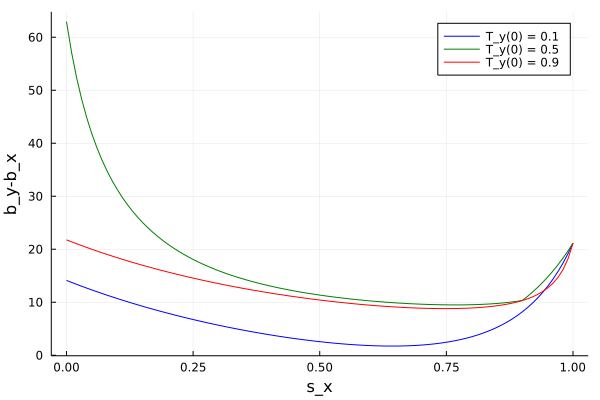

In [93]:
alpha = 0.5
beta = 0.1
nu_y = 1/(1-T_x(h_x)*s_y*T_y(h_y)*s_x/(1-s_x*(1-T_x(h_x))))*((1-T_y(h_y))*s_y*b_y/(1-s_y*(1-T_y(h_y)))+T_y(h_y)*s_x*b_x/(1-s_y*(1-T_y(h_y)))+T_y(h_y)*s_x*((1-T_x(h_x))*s_x*b_x+T_x(h_x)*s_y*b_y)/(1-s_y*(1-T_y(h_y)))/(1-s_x*(1-T_x(h_x))))

delta = zeros(101)
i=1
S_X = 0:0.01:1
for s_x in 0:0.01:1
    
    s_y = (1+s_x)/2
    #s_y = min(s_x+0.1,1)
    nu_y = 1/(1-T_x(h_x)*s_y*T_y(h_y)*s_x/(1-s_x*(1-T_x(h_x))))*((1-T_y(h_y))*s_y*b_y/(1-s_y*(1-T_y(h_y)))+T_y(h_y)*s_x*b_x/(1-s_y*(1-T_y(h_y)))+T_y(h_y)*s_x*((1-T_x(h_x))*s_x*b_x+T_x(h_x)*s_y*b_y)/(1-s_y*(1-T_y(h_y)))/(1-s_x*(1-T_x(h_x))))
    nu_x = 1/(1-s_x*(1-T_x(h_x)))*((1-T_x(h_x))*s_x*b_x+T_x(h_x)*s_y*b_y+T_x(h_x)*nu_y)

    X,Y = equilibrium()
    s_ox = 0.1
    delta[i] = 2 .*(1 .-(1 .-T_x(h_x)).*s_ox.-T_x(h_x).*s_oy.-(s_y.*nu_y.-s_x.*nu_x).*(1 .-T_x(h_x)).*R_op.+b_x.*(s_y.-s_x).*R_op)./(((1 .-phi).*(s_y.-s_x).*Y./(X.+Y).+s_y.*(1 .+phi)).*(1 .-T_x(h_x)).*R_op)
    i+=1
end
plot(S_X,delta, color = "blue",label = "T_y(0) = 0.1")


i=1
beta = 0.5
nu_y = 1/(1-T_x(h_x)*s_y*T_y(h_y)*s_x/(1-s_x*(1-T_x(h_x))))*((1-T_y(h_y))*s_y*b_y/(1-s_y*(1-T_y(h_y)))+T_y(h_y)*s_x*b_x/(1-s_y*(1-T_y(h_y)))+T_y(h_y)*s_x*((1-T_x(h_x))*s_x*b_x+T_x(h_x)*s_y*b_y)/(1-s_y*(1-T_y(h_y)))/(1-s_x*(1-T_x(h_x))))
for s_x in 0:0.01:1
    
    #s_y = (1+s_x)/2
    s_y = min(s_x+0.1,1)
    nu_y = 1/(1-T_x(h_x)*s_y*T_y(h_y)*s_x/(1-s_x*(1-T_x(h_x))))*((1-T_y(h_y))*s_y*b_y/(1-s_y*(1-T_y(h_y)))+T_y(h_y)*s_x*b_x/(1-s_y*(1-T_y(h_y)))+T_y(h_y)*s_x*((1-T_x(h_x))*s_x*b_x+T_x(h_x)*s_y*b_y)/(1-s_y*(1-T_y(h_y)))/(1-s_x*(1-T_x(h_x))))
    nu_x = 1/(1-s_x*(1-T_x(h_x)))*((1-T_x(h_x))*s_x*b_x+T_x(h_x)*s_y*b_y+T_x(h_x)*nu_y)

    X,Y = equilibrium()
    s_ox = 0.1
    delta[i] = 2 .*(1 .-(1 .-T_x(h_x)).*s_ox.-T_x(h_x).*s_oy.-(s_y.*nu_y.-s_x.*nu_x).*(1 .-T_x(h_x)).*R_op.+b_x.*(s_y.-s_x).*R_op)./(((1 .-phi).*(s_y.-s_x).*Y./(X.+Y).+s_y.*(1 .+phi)).*(1 .-T_x(h_x)).*R_op)
    i+=1
end 
plot!(S_X,delta, color = "green",label = "T_y(0) = 0.5")

i=1


beta = 0.9
nu_y = 1/(1-T_x(h_x)*s_y*T_y(h_y)*s_x/(1-s_x*(1-T_x(h_x))))*((1-T_y(h_y))*s_y*b_y/(1-s_y*(1-T_y(h_y)))+T_y(h_y)*s_x*b_x/(1-s_y*(1-T_y(h_y)))+T_y(h_y)*s_x*((1-T_x(h_x))*s_x*b_x+T_x(h_x)*s_y*b_y)/(1-s_y*(1-T_y(h_y)))/(1-s_x*(1-T_x(h_x))))
for s_x in 0:0.01:1
    
    s_y = (1+s_x)/2
    #s_y = min(s_x+0.1,1)
    nu_y = 1/(1-T_x(h_x)*s_y*T_y(h_y)*s_x/(1-s_x*(1-T_x(h_x))))*((1-T_y(h_y))*s_y*b_y/(1-s_y*(1-T_y(h_y)))+T_y(h_y)*s_x*b_x/(1-s_y*(1-T_y(h_y)))+T_y(h_y)*s_x*((1-T_x(h_x))*s_x*b_x+T_x(h_x)*s_y*b_y)/(1-s_y*(1-T_y(h_y)))/(1-s_x*(1-T_x(h_x))))
    nu_x = 1/(1-s_x*(1-T_x(h_x)))*((1-T_x(h_x))*s_x*b_x+T_x(h_x)*s_y*b_y+T_x(h_x)*nu_y)
    
    X,Y = equilibrium()
    s_ox = 0.1
    delta[i] = 2 .*(1 .-(1 .-T_x(h_x)).*s_ox.-T_x(h_x).*s_oy.-(s_y.*nu_y.-s_x.*nu_x).*(1 .-T_x(h_x)).*R_op.+b_x.*(s_y.-s_x).*R_op)./(((1 .-phi).*(s_y.-s_x).*Y./(X.+Y).+s_y.*(1 .+phi)).*(1 .-T_x(h_x)).*R_op)
    i+=1
end
plot!(S_X,delta, color = "red",label = "T_y(0) = 0.9")

xlabel!("s_x")
ylabel!("b_y-b_x")